In this notebook I explore the Linear regression model for the April 2019 preprocessed bike data and try to improve the model through adding polynomial and lag features

In [55]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import joblib

In [3]:
month = "04"
path  = f"data/od-trips-2019/2019-{month}.csv"
april_2019_OD = pd.read_csv(path)

In [ ]:
df = april_2019_OD.copy()
df['Departure'] = pd.to_datetime(df['Departure'], errors='coerce', format='mixed')
df['Return'] = pd.to_datetime(df['Return'], errors='coerce', format='mixed')

df['dep_hour'] = df['Departure'].dt.floor('h')
df['ret_hour'] = df['Return'].dt.floor('h')

# --- Hourly DEPARTURES per station ---
departures = (
    df.groupby(['Departure station id', 'dep_hour'])
      .size()
      .reset_index(name='departures')
      .rename(columns={'Departure station id': 'station_id', 'dep_hour': 'hour'})
)
# --- Hourly ARRIVALS per station ---
arrivals = (
    df.groupby(['Return station id', 'ret_hour'])
      .size()
      .reset_index(name='arrivals')
      .rename(columns={'Return station id': 'station_id', 'ret_hour': 'hour'})
)
# --- Merge them together (outer join to include hours with only dep/arr) ---
station_hourly = pd.merge(departures, arrivals,on=['station_id', 'hour'], how='outer').fillna(0)

# Get full range of hours and all station IDs
hours = pd.date_range(df['Departure'].min().floor('h'),
                      df['Return'].max().ceil('h'),
                      freq='H')
stations = df['Departure station id'].unique()
# Create full index
multi_index = pd.MultiIndex.from_product([stations, hours], names=['station_id', 'hour'])
full = pd.DataFrame(index=multi_index).reset_index()
# Merge with your counts and fill missing values with 0
station_hourly_full = pd.merge(full, station_hourly,on=['station_id', 'hour'], how='left').fillna(0)

station_hourly_full['weekday'] = station_hourly_full['hour'].dt.dayofweek
station_hourly_full['month']   = station_hourly_full['hour'].dt.month
station_hourly_full['hour_of_day'] = station_hourly_full['hour'].dt.hour

cap_df = pd.read_csv("data/Helsingin_ja_Espoon_kaupunkipyöräasemat_avoin_7704606743268189464.csv")
cap_df = cap_df[['ID', 'Kapasiteet']]
cap_df.rename(columns={'ID': 'station_id', 'Kapasiteet': 'capacity'}, inplace=True)

stations_binary = station_hourly.copy()
stations_binary = stations_binary.merge(cap_df, on="station_id", how="left")
stations_binary.dropna(subset=['capacity'], inplace=True)

# Ensure datetime format
stations_binary['hour'] = pd.to_datetime(stations_binary['hour'])
# Create full hourly timeline for all stations
full_range = pd.date_range(stations_binary['hour'].min(), stations_binary['hour'].max(), freq='H')
stations = stations_binary['station_id'].unique()
# Cartesian product: all (station, hour) pairs
full_index = pd.MultiIndex.from_product([stations, full_range], names=['station_id', 'hour'])
stations_binary_full = (
    stations_binary.set_index(['station_id', 'hour'])
      .reindex(full_index)
      .reset_index())
# Fill missing values
stations_binary_full['departures'] = stations_binary_full['departures'].fillna(0)
stations_binary_full['arrivals'] = stations_binary_full['arrivals'].fillna(0)
stations_binary_full['capacity'] = stations_binary_full.groupby('station_id')['capacity'].transform(lambda x: x.ffill().bfill())
# Compute net flow
stations_binary_full['net_flow'] = stations_binary_full['arrivals'] - stations_binary_full['departures']
# Compute cumulative available bikes per station
def compute_availability(g):
    start_val = g['capacity'].iloc[0] / 2  # assume half capacity at start
    available = start_val + g['net_flow'].cumsum()
    available = np.clip(available, 0, g['capacity'].iloc[0])  # keep within [0, capacity]
    g['available_bikes'] = available
    return g
stations_binary_full = stations_binary_full.groupby('station_id', group_keys=False).apply(compute_availability)
# Add binary column “empty”
stations_binary_full['empty'] = (stations_binary_full['available_bikes'] <= 0).astype(int)
# Add time-based covariates
stations_binary_full['hour_of_day'] = stations_binary_full['hour'].dt.hour
stations_binary_full['day_of_week'] = stations_binary_full['hour'].dt.dayofweek  # Monday = 0
stations_binary_full['month'] = stations_binary_full['hour'].dt.month
stations_binary_full['is_weekend'] = stations_binary_full['day_of_week'].isin([5, 6]).astype(int)

df_full = stations_binary_full.copy()


/tmp/ipykernel_910686/2314411284.py:26: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(df['Departure'].min().floor('h'),
/tmp/ipykernel_910686/2314411284.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(stations_binary['hour'].min(), stations_binary['hour'].max(), freq='H')
/tmp/ipykernel_910686/2314411284.py:72: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_binary_full = stations_binary_full.groupby('station_id', group_keys=False).apply(compute_availability)


In [5]:
df_full

,station_id,hour,departures,arrivals,capacity,net_flow,available_bikes,empty,hour_of_day,day_of_week,month,is_weekend
0,1.0,2019-04-01 05:00:00,0.0,0.0,30.0,0.0,15.0,0,5,0,4,0
1,1.0,2019-04-01 06:00:00,0.0,0.0,30.0,0.0,15.0,0,6,0,4,0
2,1.0,2019-04-01 07:00:00,0.0,0.0,30.0,0.0,15.0,0,7,0,4,0
3,1.0,2019-04-01 08:00:00,0.0,2.0,30.0,2.0,17.0,0,8,0,4,0
4,1.0,2019-04-01 09:00:00,0.0,0.0,30.0,0.0,17.0,0,9,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
415397,769.0,2019-05-22 05:00:00,0.0,0.0,12.0,0.0,0.0,1,5,2,5,0
415398,769.0,2019-05-22 06:00:00,0.0,0.0,12.0,0.0,0.0,1,6,2,5,0
415399,769.0,2019-05-22 07:00:00,0.0,0.0,12.0,0.0,0.0,1,7,2,5,0
415400,769.0,2019-05-22 08:00:00,0.0,0.0,12.0,0.0,0.0,1,8,2,5,0


## Linear regression model (not binary classifier)

In [6]:

# Features and target
features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend', 'station_id']
target = 'available_bikes'

X = df_full[features]
y = df_full[target]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessing ---
# Numeric features
numeric_features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend']

# Categorical features (station_id → one-hot encoding)
categorical_features = ['station_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# --- Linear Regression Model ---
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model trained!")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


Model trained!
Root Mean Squared Error (RMSE): 4.20
R² Score: 0.771


In [56]:
joblib.dump(model, "basic_linreg_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


Positive coefficient: Increases the expected number of available bikes.

Negative coefficient: Decreases it (i.e., likely busier times or stations).

Large magnitude: Stronger influence on predictions.

and

For hour_of_day or day_of_week, this shows temporal trends.

For station one-hot features (cat__station_id_*), these represent baseline differences across stations.

In [11]:
# Extract coefficients after fitting
regressor = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

coeffs = pd.DataFrame({
    'feature': feature_names,
    'coefficient': regressor.coef_
}).sort_values(by='coefficient', ascending=False)

print(coeffs.head(10))


                   feature  coefficient
67    cat__station_id_65.0    28.828872
43    cat__station_id_41.0    24.646701
14    cat__station_id_12.0    24.035246
149  cat__station_id_161.0    23.577180
275  cat__station_id_581.0    21.632254
296  cat__station_id_625.0    21.041193
270  cat__station_id_571.0    20.385697
135  cat__station_id_137.0    20.326236
4      cat__station_id_1.0    20.289902
125  cat__station_id_127.0    20.023405


In [8]:
feature_names

array(['num__hour_of_day', 'num__day_of_week', 'num__month',
       'num__is_weekend', 'cat__station_id_1.0', 'cat__station_id_2.0',
       'cat__station_id_3.0', 'cat__station_id_4.0',
       'cat__station_id_5.0', 'cat__station_id_6.0',
       'cat__station_id_7.0', 'cat__station_id_8.0',
       'cat__station_id_10.0', 'cat__station_id_11.0',
       'cat__station_id_12.0', 'cat__station_id_13.0',
       'cat__station_id_14.0', 'cat__station_id_15.0',
       'cat__station_id_16.0', 'cat__station_id_17.0',
       'cat__station_id_18.0', 'cat__station_id_19.0',
       'cat__station_id_20.0', 'cat__station_id_21.0',
       'cat__station_id_22.0', 'cat__station_id_23.0',
       'cat__station_id_24.0', 'cat__station_id_25.0',
       'cat__station_id_26.0', 'cat__station_id_27.0',
       'cat__station_id_28.0', 'cat__station_id_29.0',
       'cat__station_id_30.0', 'cat__station_id_31.0',
       'cat__station_id_32.0', 'cat__station_id_33.0',
       'cat__station_id_34.0', 'cat__station_id_

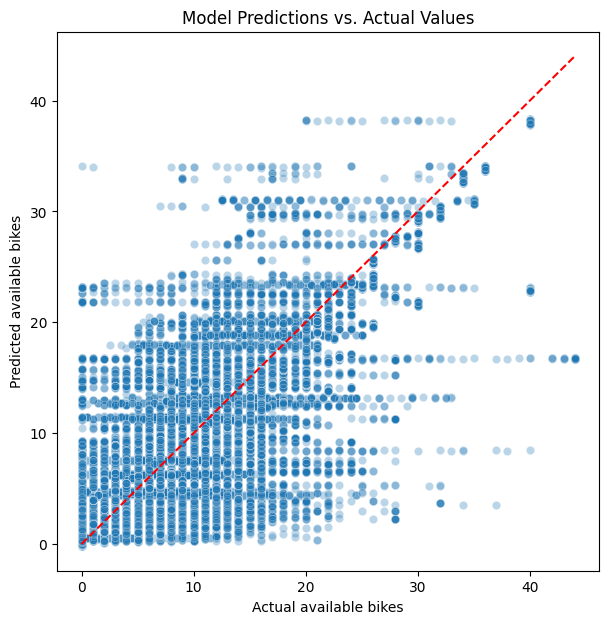

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

Our linear regression predictor is not that great here (r² = 0.77)

## Plotting residuals

Residuals = actual − predicted

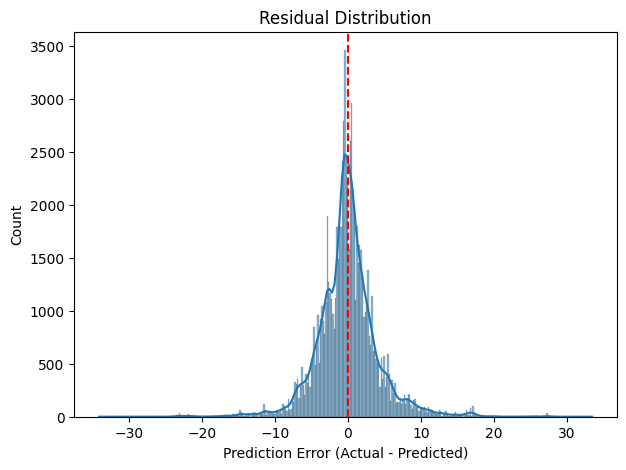

In [13]:
residuals = y_test - y_pred

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [24]:
residuals.max(), residuals.min()

(np.float64(33.47869774647437), np.float64(-34.07568258692977))

Yikes, good models have residuals roughly centered around zero with no obvious pattern. Centered near 0 → unbiased predictions. Wide or skewed → under/overestimation patterns or missing features.

## Plotting the hourly and daily trend of predicted vs actual

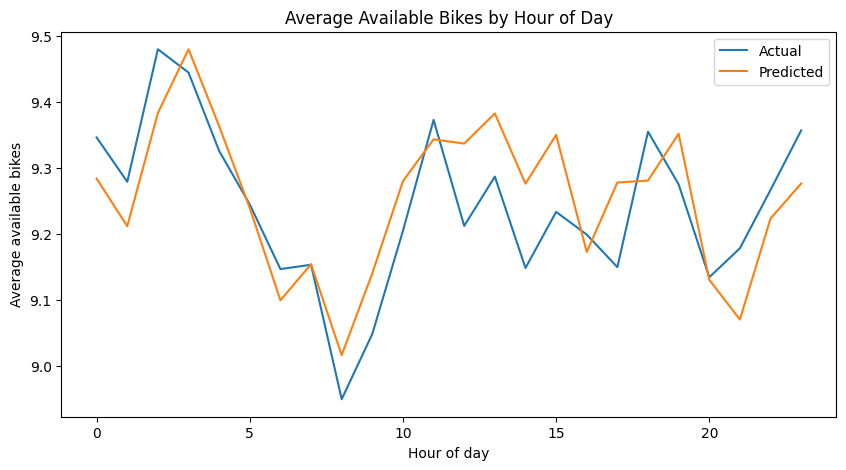

In [14]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()


Pretty good, our model follow the general trend with some (not too significant) deviations'

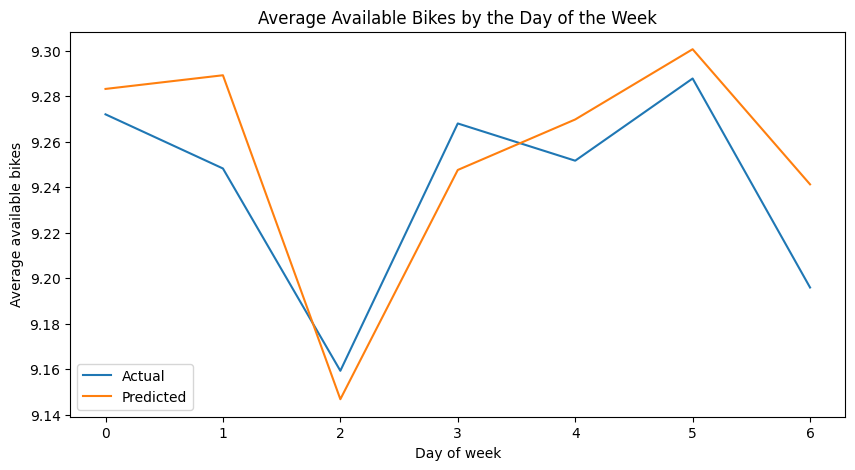

In [19]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

Not too bad

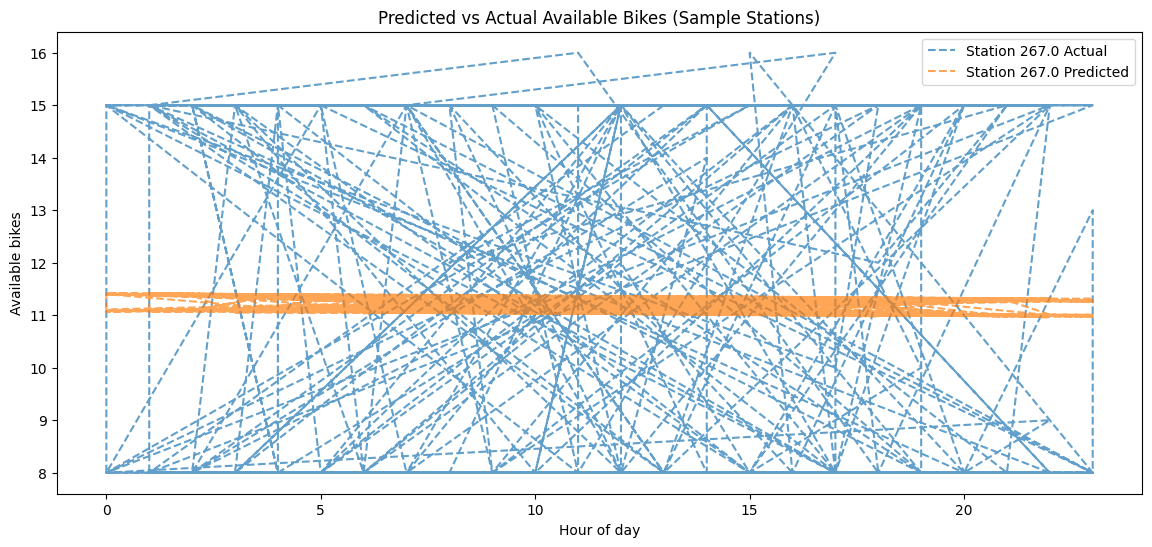

In [32]:
sample_stations = np.random.choice(X_test['station_id'].unique(), size=1, replace=False)

plt.figure(figsize=(14,6))
for station in sample_stations:
    station_data = X_test_copy[X_test_copy['station_id'] == station]
    plt.plot(station_data['hour_of_day'], station_data['y_true'], '--', label=f'Station {station} Actual', alpha=0.7)
    plt.plot(station_data['hour_of_day'], station_data['y_pred'], '--', label=f'Station {station} Predicted', alpha=0.7)

plt.title("Predicted vs Actual Available Bikes (Sample Stations)")
plt.xlabel("Hour of day")
plt.ylabel("Available bikes")
plt.legend()
plt.show()

Variation in predicted is too narrow compared to the actual --> this model is too simple and tries to fit a linear trend to a complex and multi-variable dependent system such as this... 

***

# Trying modified Linear regression models

## 1. Using Polynomial Features 

Using polynomial features and interaction terms (hour × day, hour², etc.) to let the linear model capture curved relationships.
This lets the model fit U-shaped daily availability patterns (e.g., low in morning and evening)

In [33]:
from sklearn.preprocessing import PolynomialFeatures
# Features and target
features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend', 'station_id']
target = 'available_bikes'

X = df_full[features]
y = df_full[target]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessing ---
# Numeric features
numeric_features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend']

# Categorical features (station_id → one-hot encoding)
categorical_features = ['station_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

poly = PolynomialFeatures(degree=2, include_bias=False)
model_poly = Pipeline(steps=[
    ('preprocessor', preprocessor),   # Your ColumnTransformer
    ('poly', poly),
    ('regressor', LinearRegression())
])

model_poly.fit(X_train, y_train)
y_pred_poly = model_poly.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2 = r2_score(y_test, y_pred_poly)

print(f"Model trained!")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


Model trained!
Root Mean Squared Error (RMSE): 3.32
R² Score: 0.857


Okay! We can already see a better r² term!

In [57]:
joblib.dump(model_poly, "poly_linreg_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


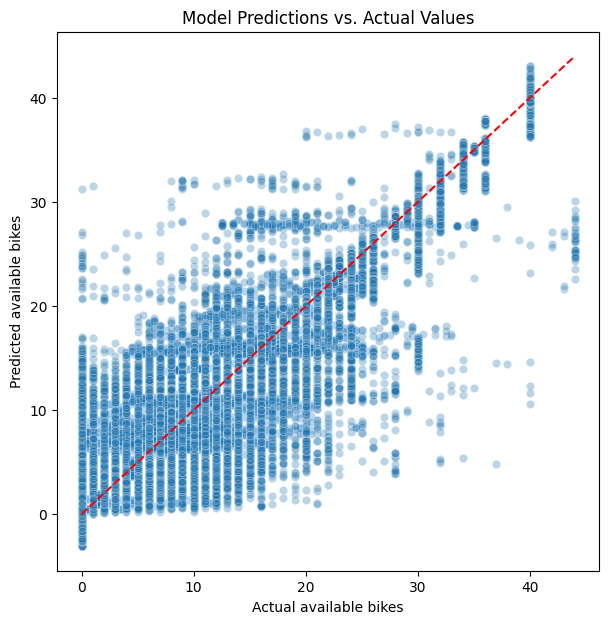

In [34]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred_poly, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

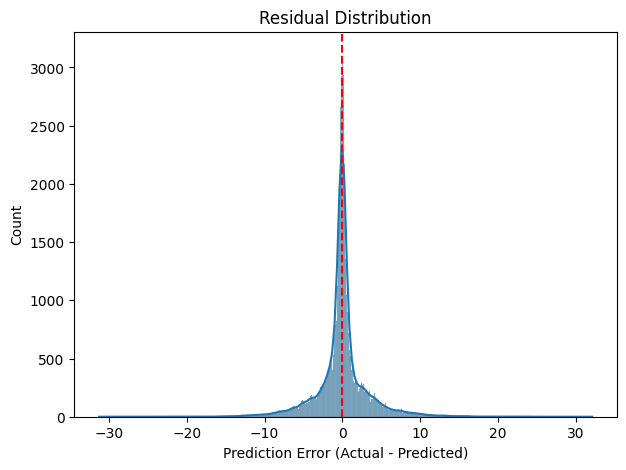

In [35]:
residuals = y_test - y_pred_poly

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [36]:
residuals.max(), residuals.min()

(np.float64(32.14433447699829), np.float64(-31.28083001435534))

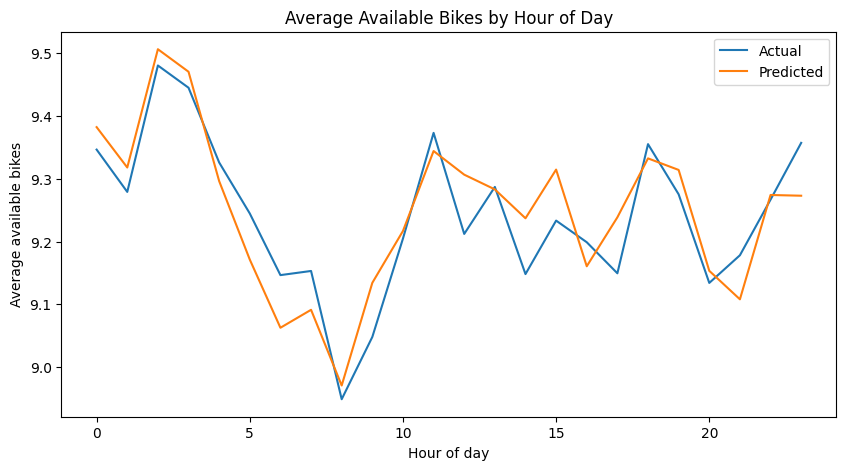

In [37]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()

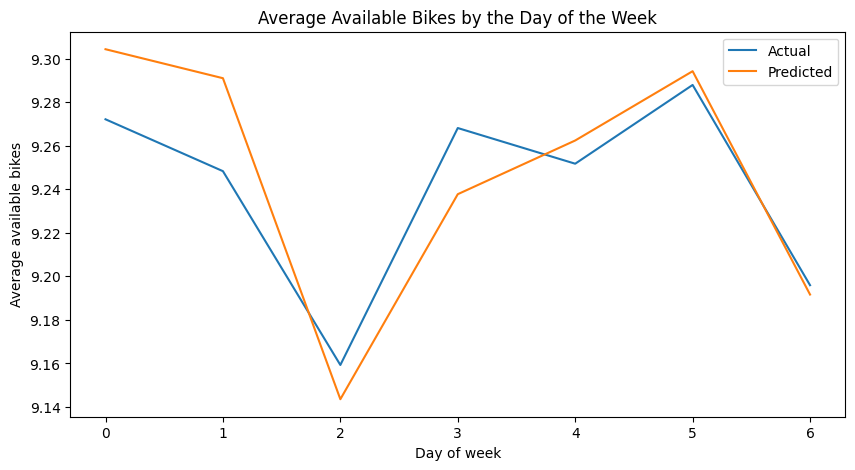

In [38]:
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

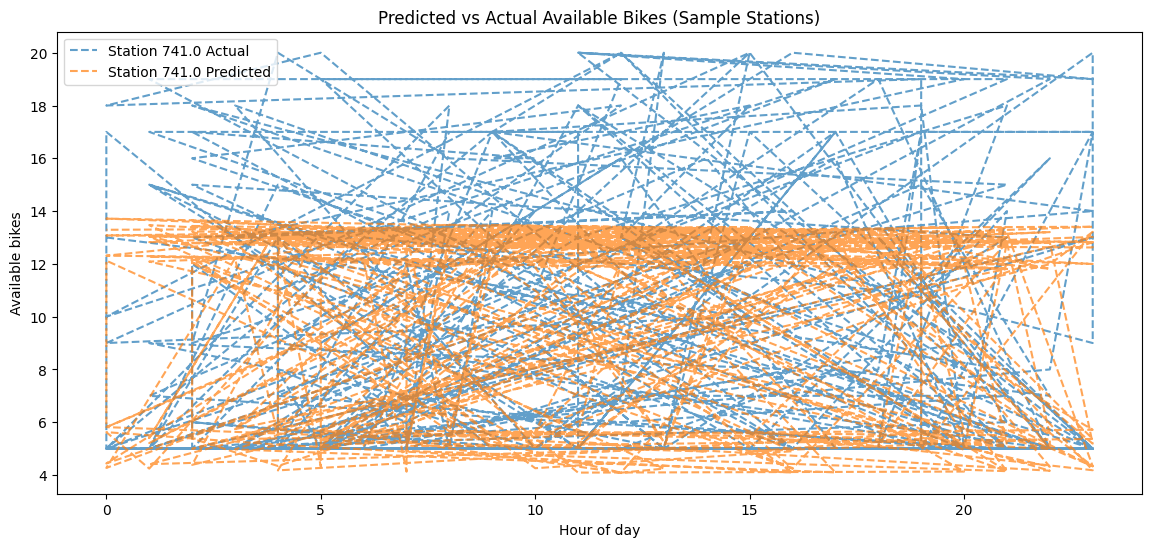

In [39]:
sample_stations = np.random.choice(X_test['station_id'].unique(), size=1, replace=False)

plt.figure(figsize=(14,6))
for station in sample_stations:
    station_data = X_test_copy[X_test_copy['station_id'] == station]
    plt.plot(station_data['hour_of_day'], station_data['y_true'], '--', label=f'Station {station} Actual', alpha=0.7)
    plt.plot(station_data['hour_of_day'], station_data['y_pred'], '--', label=f'Station {station} Predicted', alpha=0.7)

plt.title("Predicted vs Actual Available Bikes (Sample Stations)")
plt.xlabel("Hour of day")
plt.ylabel("Available bikes")
plt.legend()
plt.show()

Already looking way better! But still not as good as it could be....

***

## 2. Adding Lag features AND Using Polynomial Features 

### Adding lag terms (since every consecutive value depends on each other in time series data)

In [40]:
df_lag = df_full.copy()
df_lag['hour'] = pd.to_datetime(df_lag['hour'])

# Sort for lag features
df_lag = df_lag.sort_values(['station_id', 'hour'])

# --- ADD LAG FEATURES ---
df_lag['prev_available'] = df_lag.groupby('station_id')['available_bikes'].shift(1)
df_lag['prev_departures'] = df_lag.groupby('station_id')['departures'].shift(1)
df_lag['prev_arrivals'] = df_lag.groupby('station_id')['arrivals'].shift(1)

# Drop first hour for each station (NaNs)
df_lag = df_lag.dropna(subset=['prev_available', 'prev_departures', 'prev_arrivals'])

# --- FEATURE ENGINEERING ---
df_lag['hour_of_day'] = df_lag['hour'].dt.hour
df_lag['day_of_week'] = df_lag['hour'].dt.dayofweek
df_lag['month'] = df_lag['hour'].dt.month
df_lag['is_weekend'] = (df_lag['day_of_week'] >= 5).astype(int)

In [41]:
# --- Features and Target ---
features = ['station_id', 'hour_of_day', 'day_of_week', 'month', 'is_weekend',
            'departures', 'arrivals', 'capacity',
            'prev_available', 'prev_departures', 'prev_arrivals']
target = 'available_bikes'

X = df_lag[features]
y = df_lag[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocessing ---
numeric_features = ['hour_of_day', 'day_of_week', 'month', 'is_weekend',
                    'departures', 'arrivals', 'capacity',
                    'prev_available', 'prev_departures', 'prev_arrivals']
categorical_features = ['station_id']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# --- Linear Regression Model ---
poly = PolynomialFeatures(degree=2, include_bias=False)
model_poly_lag = Pipeline(steps=[
    ('preprocessor', preprocessor),   # Your ColumnTransformer
    ('poly', poly),
    ('regressor', LinearRegression())
])

model_poly_lag.fit(X_train, y_train)
y_pred_poly_lag = model_poly_lag.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred_poly_lag))
r2 = r2_score(y_test, y_pred_poly_lag)

print("=== Linear Regression with Lag Features ===")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


=== Linear Regression with Lag Features ===
RMSE: 0.56
R²: 0.996


R² LOOKS GREAT! But training took 3.5 minutes (this is only for one months worth of data....)

In [58]:
joblib.dump(model_poly_lag, "poly_lag_linreg_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


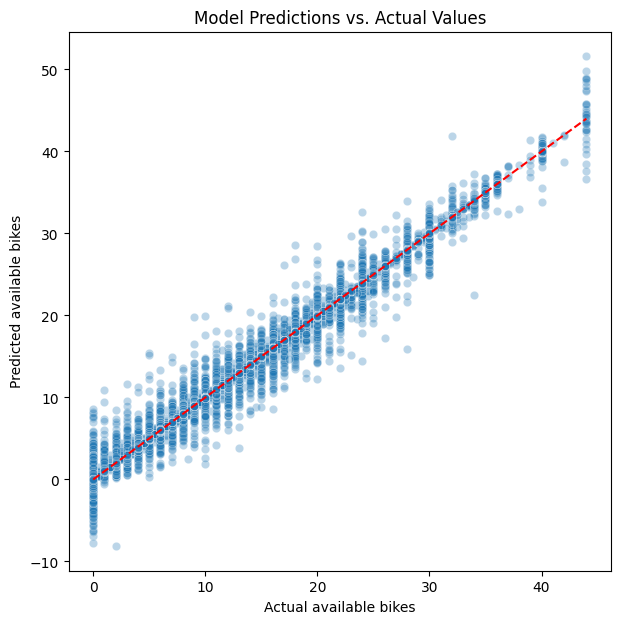

In [42]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred_poly_lag, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual available bikes")
plt.ylabel("Predicted available bikes")
plt.title("Model Predictions vs. Actual Values")
plt.show()

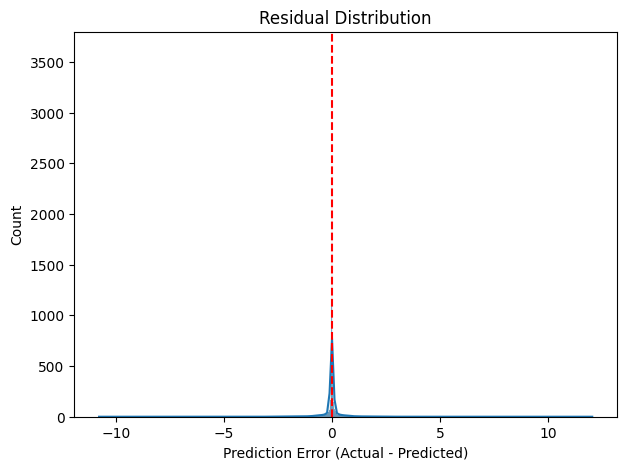

In [43]:
residuals = y_test - y_pred_poly_lag

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.show()

In [44]:
residuals.max(), residuals.min()

(np.float64(12.049196593120122), np.float64(-10.771509607419517))

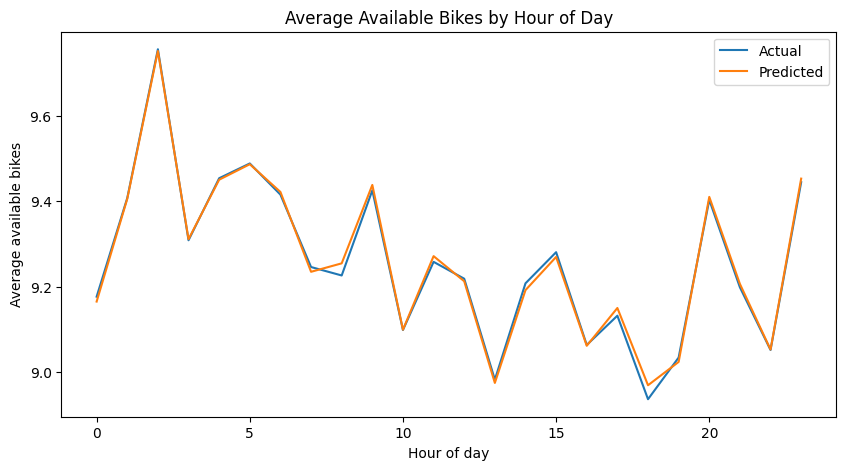

In [45]:
# Add predictions back to test set
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly_lag

# Plot average availability by hour
hourly_avg = X_test_copy.groupby('hour_of_day')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_true', label='Actual')
sns.lineplot(data=hourly_avg, x='hour_of_day', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by Hour of Day")
plt.ylabel("Average available bikes")
plt.xlabel("Hour of day")
plt.legend()
plt.show()

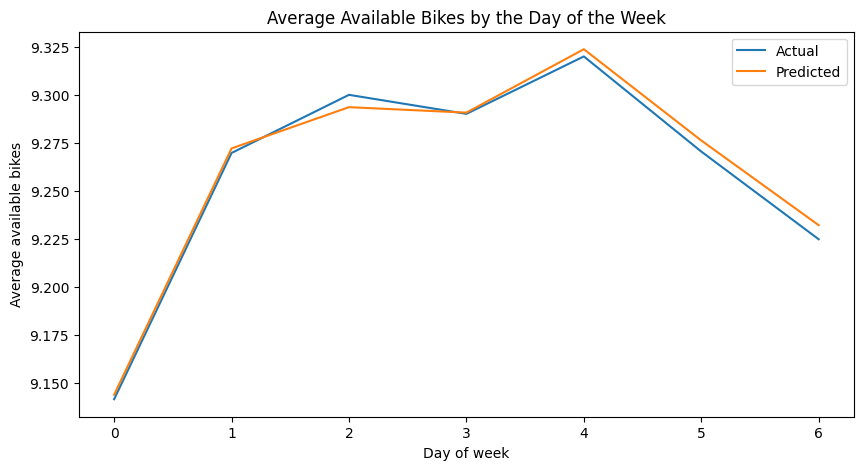

In [46]:
X_test_copy = X_test.copy()
X_test_copy['y_true'] = y_test
X_test_copy['y_pred'] = y_pred_poly_lag

# Plot average availability by hour
daily_avg = X_test_copy.groupby('day_of_week')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=daily_avg, x='day_of_week', y='y_true', label='Actual')
sns.lineplot(data=daily_avg, x='day_of_week', y='y_pred', label='Predicted')
plt.title("Average Available Bikes by the Day of the Week")
plt.ylabel("Average available bikes")
plt.xlabel("Day of week")
plt.legend()
plt.show()

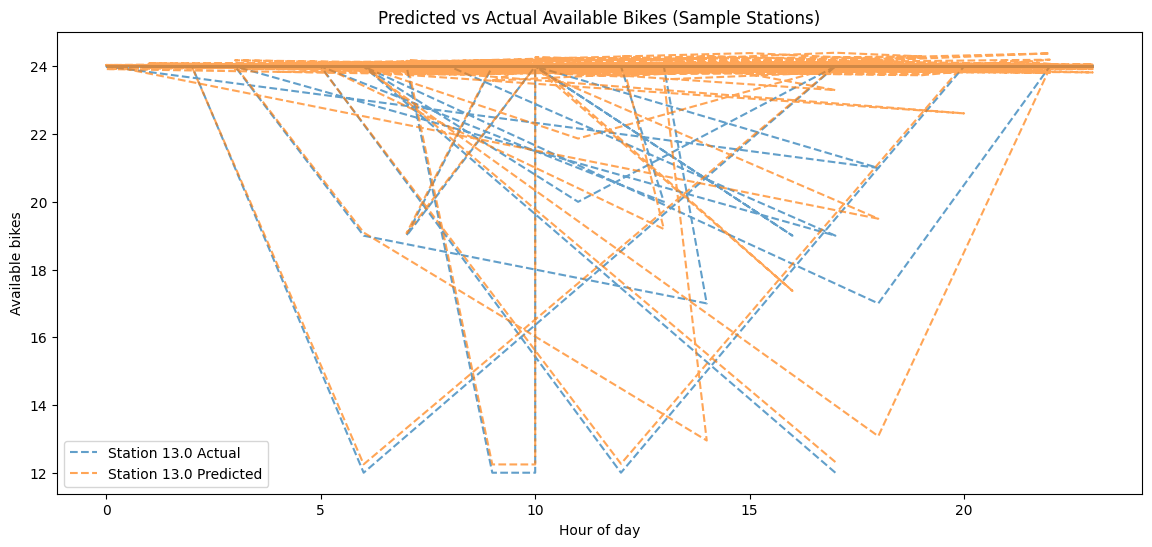

In [47]:
sample_stations = np.random.choice(X_test['station_id'].unique(), size=1, replace=False)

plt.figure(figsize=(14,6))
for station in sample_stations:
    station_data = X_test_copy[X_test_copy['station_id'] == station]
    plt.plot(station_data['hour_of_day'], station_data['y_true'], '--', label=f'Station {station} Actual', alpha=0.7)
    plt.plot(station_data['hour_of_day'], station_data['y_pred'], '--', label=f'Station {station} Predicted', alpha=0.7)

plt.title("Predicted vs Actual Available Bikes (Sample Stations)")
plt.xlabel("Hour of day")
plt.ylabel("Available bikes")
plt.legend()
plt.show()

I think we found our model!!

***

### Ridge regression is just linear regression but with a penalty to avoid noisy data from making the coef too large --> smoother and more generalized

In [53]:
poly = PolynomialFeatures(degree=2, include_bias=False)

# --- Ridge Regression Model ---
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('regressor', Ridge(alpha=1.0))
])

# Train
ridge_model.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge_model.predict(X_test)

# --- Evaluate ---
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("\n=== Ridge Regression with Lag and Polynomial Features ===")
print(f"RMSE: {rmse_ridge:.2f}")
print(f"R²: {r2_ridge:.3f}")



=== Ridge Regression with Lag and Polynomial Features ===
RMSE: 0.56
R²: 0.996


In [59]:
joblib.dump(ridge_model, "poly_lag_ridge_model_042019.pkl")
print("Model saved successfully!")

Model saved successfully!


In [54]:
comparison = pd.DataFrame({
    'Model': ['Linear (with lags+poly)', 'Ridge (with lags+poly)'],
    'RMSE': [rmse, rmse_ridge],
    'R²': [r2, r2_ridge]
})

print(comparison)


                     Model      RMSE        R²
0  Linear (with lags+poly)  0.562734  0.995902
1   Ridge (with lags+poly)  0.563861  0.995886


## Gives SLIGHTLY worse results (expected kinda cus of the penalty term added), but takes half the time